[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

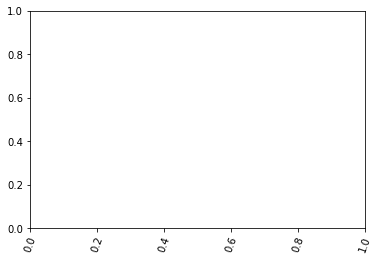

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.neighbors


import urllib.request


import zipfile
import os
import nltk
import string
import fasttext
import contractions

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

## Read Dataset and Pre-process it

In [2]:
data = pd.read_csv('final_dataset.csv')
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,overall,reviewerID,asin,reviewText,summary,category
0,0,2.0,A3HX4X3TIABWOV,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,AMAZON_FASHION
1,1,2.0,AW8UBYMNJ894V,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,AMAZON_FASHION
2,2,2.0,A3HX4X3TIABWOV,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,AMAZON_FASHION
3,3,2.0,AW8UBYMNJ894V,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,AMAZON_FASHION
4,4,1.0,A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,AMAZON_FASHION


In [8]:
# Removes nulls and nans
data['reviewText'].fillna("", inplace = True)
data['summary'].fillna("", inplace = True)
data = data[data['reviewerID'].notna()]
data = data[data['asin'].notna()]
data = data[data['category'].notna()]
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,overall,reviewerID,asin,reviewText,summary,category
0,2.0,A3HX4X3TIABWOV,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,AMAZON_FASHION
1,2.0,AW8UBYMNJ894V,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,AMAZON_FASHION
2,2.0,A3HX4X3TIABWOV,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,AMAZON_FASHION
3,2.0,AW8UBYMNJ894V,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,AMAZON_FASHION
4,1.0,A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,AMAZON_FASHION


In [9]:
#check for nulls
for col in data.columns:
    print(col, data[col].isnull().sum())

overall 0
reviewerID 0
asin 0
reviewText 0
summary 0
category 0


In [10]:
#Remove unnecessary columns
rws = data.loc[:, ['asin', 'reviewText', 'summary', 'overall', 'reviewerID', 'category']]
rws

,asin,reviewText,summary,overall,reviewerID,category
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION
...,...,...,...,...,...,...
7714619,B01HGPUTCA,not OEM but good replacement parts,Four Stars,4.0,AVECM71LSZLC5,Video_Games
7714620,B01HH6JEOC,Okay stuff.,Three Stars,3.0,A1RS06313BL6WN,Video_Games
7714621,B01HH6JEOC,"This does add some kids room things that are very nice in their own right, this doesn't seem to ...",Only buy on sale.,3.0,ACIZ77IGIX2JL,Video_Games
7714622,B01HIZF7XE,"I think I originally began playing Bioshock several years ago, but wasn't leveled up enough or d...","It's Okay, Nothing Profound",4.0,A34GG58TJ1A3SH,Video_Games


In [11]:
# Devide Dataset because it is too big

rws_1 = rws.iloc[:1000000]
#rws_2 = rws.iloc[1000000:2000000]
#rws_3 = rws.iloc[2000000:3000000]
#rws_4 = rws.iloc[3000000:4000000]
#rws_5 = rws.iloc[4000000:5000000]
#rws_6 = rws.iloc[5000000:6000000]
#rws_7 = rws.iloc[6000000:]

# Pre-Processing for Sentiment

In [12]:

punc = string.punctuation
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

## Remove Contractions

In [13]:
rws_1['no_contract'] = rws_1['reviewText'].apply(lambda x: [contractions.fix(word) for word in x.split()])
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full..."
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full..."
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION,"[Waaaay, too, BIG]"


In [14]:
#review without contractions
rws_1['rating_description_str'] = [' '.join(map(str, l)) for l in rws_1['no_contract']]
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION,"[Waaaay, too, BIG]",Waaaay too BIG


## Tokenizer using NLTK

In [15]:
rws_1['tokenized'] = rws_1['rating_description_str'].apply(word_tokenize)
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu..."
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu..."
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION,"[Waaaay, too, BIG]",Waaaay too BIG,"[Waaaay, too, BIG]"


## Put To Lowercase

In [16]:
rws_1['lower'] = rws_1['tokenized'].apply(lambda x: [word.lower() for word in x])
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized,lower
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu..."
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu..."
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION,"[Waaaay, too, BIG]",Waaaay too BIG,"[Waaaay, too, BIG]","[waaaay, too, big]"


## Remove Punctuation

In [17]:
rws_1['no_punc'] = rws_1['lower'].apply(lambda x: [word for word in x if word not in punc])
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized,lower,no_punc
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,..."
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,..."
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a..."
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION,"[Waaaay, too, BIG]",Waaaay too BIG,"[Waaaay, too, BIG]","[waaaay, too, big]","[waaaay, too, big]"


## Remove Stopwords

In [18]:
rws_1['stopwords_removed'] = rws_1['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
rws_1

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized,lower,no_punc,stopwords_removed
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod..."
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuromas, unfortunately, ones, ord..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod..."
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuromas, unfortunately, ones, ord..."
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION,"[Waaaay, too, BIG]",Waaaay too BIG,"[Waaaay, too, BIG]","[waaaay, too, big]","[waaaay, too, big]","[waaaay, big]"
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,B000EX15NY,"Terrible! Like other reviewers, I suspect the all black ones are knock-offs. They are not comfor...","Possible Knock-Offs - Poor Quality, Rough, Squeaky, Stain Feet",1.0,A16KH8DV9E9NPQ,Clothing_Shoes_and_Jewelry,"[Terrible!, Like, other, reviewers,, I, suspect, the, all, black, ones, are, knock-offs., They, ...","Terrible! Like other reviewers, I suspect the all black ones are knock-offs. They are not comfor...","[Terrible, !, Like

## Tag Words

In [19]:
rws_1['pos_tags'] = rws_1['stopwords_removed'].apply(nltk.tag.pos_tag)
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod...","[(relieved, VBN), (plantar, NN), (fascitis, NN), (3, CD), (days, NNS), (unbearable, JJ), (pain, ..."
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuromas, unfortunately, ones, ord...","[(6th, CD), (pair, NN), (best, RBS), (thing, NN), (ever, RB), (plantar, VBZ), (fasciitis, NN), (..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod...","[(relieved, VBN), (plantar, NN), (fascitis, NN), (3, CD), (days, NNS), (unbearable, JJ), (pain, ..."
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuromas, unfortunately, ones, ord...","[(6th, CD), (pair, NN), (best, RBS), (thing, NN), (ever, RB), (plantar, VBZ), (fasciitis, NN), (..."
4,B000YFSR5G,Waaaay too BIG,One Star,1.0,A3QY3THQ42WSCQ,AMAZON_FASHION,"[Waaaay, too, BIG]",Waaaay too BIG,"[Waaaay, too, BIG]","[waaaay, too, big]","[waaaay, too, big]","[waaaay, big]","[(waaaay, NN), (big, JJ)]"


## Named-Entity Recognition

In [20]:
rws_1['wordnet_pos'] = rws_1['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod...","[(relieved, VBN), (plantar, NN), (fascitis, NN), (3, CD), (days, NNS), (unbearable, JJ), (pain, ...","[(relieved, v), (plantar, n), (fascitis, n), (3, n), (days, n), (unbearable, a), (pain, n), (ret..."
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuromas, unfortunately, ones, ord...","[(6th, CD), (pair, NN), (best, RBS), (thing, NN), (ever, RB), (plantar, VBZ), (fasciitis, NN), (...","[(6th, n), (pair, n), (best, r), (thing, n), (ever, r), (plantar, v), (fasciitis, n), (resultant..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod...","[(relieved, VBN), (plantar, NN), (fascitis, NN), (3, CD), (days, NNS), (unbearable, JJ), (pain, ...","[(relieved, v), (plantar, n), (fascitis, n), (3, n), (days, n), (unbearable, a), (pain, n), (ret..."
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuromas, unfortunately, ones, ord...","[(6th, CD), (pair, NN), (best, RBS), (thing, NN), (ever, R

## Lemmatize Wordnet

In [21]:
rws_1['lemmatized'] = rws_1['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
rws_1.head()

,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,B000KPIHQ4,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod...","[(relieved, VBN), (plantar, NN), (fascitis, NN), (3, CD), (days, NNS), (unbearable, JJ), (pain, ...","[(relieved, v), (plantar, n), (fascitis, n), (3, n), (days, n), (unbearable, a), (pain, n), (ret...","[relieve, plantar, fascitis, 3, day, unbearable, pain, return, full, force, recommend, podiatrist]"
1,B000KPIHQ4,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuromas, unfortunately, ones, ord...","[(6th, CD), (pair, NN), (best, RBS), (thing, NN), (ever, RB), (plantar, VBZ), (fasciitis, NN), (...","[(6th, n), (pair, n), (best, r), (thing, n), (ever, r), (plantar, v), (fasciitis, n), (resultant...","[6th, pair, best, thing, ever, plantar, fasciitis, resultant, neuroma, unfortunately, one, order..."
2,B000V0IBDM,Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,These were recommended by my Podiatrist,2.0,A3HX4X3TIABWOV,AMAZON_FASHION,"[Relieved, my, Plantar, Fascitis, for, 3, Days., Then, the, unbearable, pain, returned, in, full...",Relieved my Plantar Fascitis for 3 Days. Then the unbearable pain returned in full force. These ...,"[Relieved, my, Plantar, Fascitis, for, 3, Days, ., Then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, ., then, the, unbearable, pain, returned, in, fu...","[relieved, my, plantar, fascitis, for, 3, days, then, the, unbearable, pain, returned, in, full,...","[relieved, plantar, fascitis, 3, days, unbearable, pain, returned, full, force, recommended, pod...","[(relieved, VBN), (plantar, NN), (fascitis, NN), (3, CD), (days, NNS), (unbearable, JJ), (pain, ...","[(relieved, v), (plantar, n), (fascitis, n), (3, n), (days, n), (unbearable, a), (pain, n), (ret...","[relieve, plantar, fascitis, 3, day, unbearable, pain, return, full, force, recommend, podiatrist]"
3,B000V0IBDM,This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,Not the same as all my other pairs.,2.0,AW8UBYMNJ894V,AMAZON_FASHION,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...",This is my 6th pair and they are the best thing ever for my plantar fasciitis and resultant neur...,"[This, is, my, 6th, pair, and, they, are, the, best, thing, ever, for, my, plantar, fasciitis, a...","[this, is, my, 6th, pair, and, they, are, the, be

In [22]:
#save dataset
rws_1.to_csv('rws_1.csv')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

(S
  relieved/VBN
  plantar/NN
  fascitis/NN
  3/CD
  days/NNS
  unbearable/JJ
  pain/NN
  returned/VBD
  full/JJ
  force/NN
  recommended/VBD
  podiatrist/NN)


TclError: no display name and no $DISPLAY environment variable

Tree('S', [('relieved', 'VBN'), ('plantar', 'NN'), ('fascitis', 'NN'), ('3', 'CD'), ('days', 'NNS'), ('unbearable', 'JJ'), ('pain', 'NN'), ('returned', 'VBD'), ('full', 'JJ'), ('force', 'NN'), ('recommended', 'VBD'), ('podiatrist', 'NN')])